In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Set constants
HEIGHT = 100
WIDTH = 180

# Custom Weighted MSE Loss

def WeightedMSELoss(y_true: tf.Tensor, y_pred: tf.Tensor):  # in actuallity MSE might not be a good loss because of equidistance might use a sigmoid ish thing instead

    with tf.device('/CPU:0'):
      y_true_copy = tf.identity(y_true)

    y_true_list = tf.keras.backend.eval(y_true_copy)

    mutation_pos = set()  # place holder for now
    ref = y_true_list[0]  # (WIDTH, 1)
    for seq in y_true_list:
      for i, (base1, base2) in enumerate(zip(seq, ref)):
        if base1[0] != base2[0]:
          mutation_pos.add(i)
    mutation_pos = list(mutation_pos)

    # Calculate squared error
    squared_error = tf.square(y_true - y_pred)

    # generate weight
    tensor_shape = (HEIGHT, WIDTH)
    weight_tensor = tf.zeros(tensor_shape)
    for i in range(tensor_shape[0]):
        weight_tensor = tf.tensor_scatter_nd_add(weight_tensor, indices=[[i, pos] for pos in mutation_pos], updates=(tf.ones_like(mutation_pos, dtype=tf.float32)))
    weight_tensor = weight_tensor * 34
    weight_tensor = weight_tensor + 1
    weight_tensor = tf.reshape(weight_tensor, [HEIGHT, WIDTH, 1])

    # apply weights
    weighted_squared_error = squared_error * weight_tensor

    # compute mean of loss
    loss = tf.reduce_mean(weighted_squared_error)

    return loss

In [3]:
# with tf.keras.utils.custom_object_scope({'WeightedMSELoss': WeightedMSELoss}):
#     model = tf.keras.models.load_model(f'model1_vgg_generic_weighted_epochs_23122023')

model = tf.keras.models.load_model(f'model_DNA_NET_GENERAL_MODEL_SMALL')

In [4]:
import PickleUtil

pk = PickleUtil.PickleLoader(clones=["3D7", "7G8", "DD2"])

In [5]:
def dna_sequence_to_numeric(dna_sequence_list):
    base_mapping = {"A": 0, "C": 1, "G": 2, "T": 3}
    num_sequences = len(dna_sequence_list)
    max_sequence_length = max(len(seq) for seq in dna_sequence_list)

    # Initialize a 2D NumPy array filled with zeros
    numeric_array = np.zeros((num_sequences, max_sequence_length), dtype=int)

    for i, seq in enumerate(dna_sequence_list):
        for j, base in enumerate(seq):
            numeric_array[i, j] = base_mapping.get(base, -1)

    return numeric_array

In [6]:
[_3D7_data, _7G8_data, _DD2_data] = pk.load_pickle()

In [7]:
mix_data = np.concatenate((_3D7_data, _7G8_data, _DD2_data))
np.random.shuffle(mix_data)

In [18]:
crt_image_sameple = np.array([dna_sequence_to_numeric(mix_data[1240:1340])]).astype('float32') / 3
crt_image_sameple = crt_image_sameple.reshape(crt_image_sameple.shape[0], 100, 178, 1)
padding_config = ((0, 0), (0, 0), (0, 22), (0, 0))  # (before, after) for each dimension
crt_image_sameple = np.pad(crt_image_sameple, padding_config, mode='constant', constant_values=1)
crt_image_sameple.shape

(1, 100, 200, 1)

In [19]:
denoised_image = model.predict(crt_image_sameple)

1/1 [==============================] - 0s 124ms/step


In [20]:
reshaped_test_data = np.round(denoised_image[0] * 3).reshape(100,200)

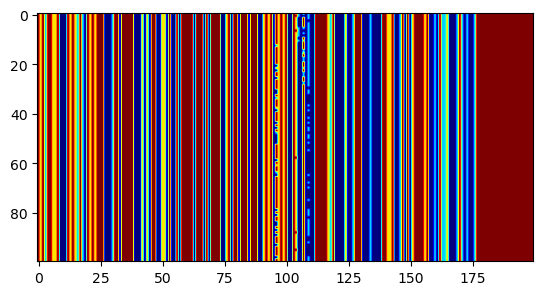

In [21]:
plt.imshow(reshaped_test_data, cmap="jet")
plt.show()

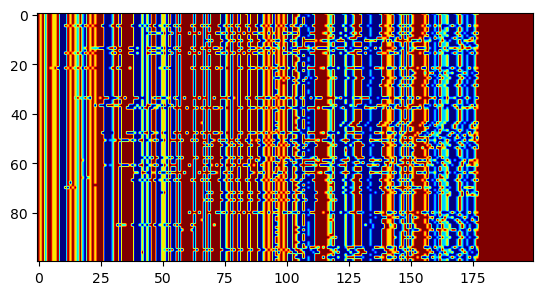

In [22]:
plt.imshow(np.round(crt_image_sameple[0] * 3).reshape(100,200), cmap="jet")
plt.show()

In [23]:
finetuned_model = tf.keras.models.load_model(f'model_DNA_NET_CRT_24012024')

In [24]:
denoised_image2 = finetuned_model.predict(crt_image_sameple)

1/1 [==============================] - 0s 311ms/step


In [25]:
reshaped_test_data2 = np.round(denoised_image2[0] * 3).reshape(100,200)

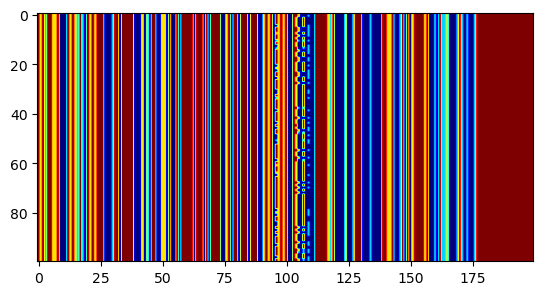

In [26]:
plt.imshow(reshaped_test_data2, cmap="jet")
plt.show()